In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21084165.69it/s]                            


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


32768it [00:00, 316332.67it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


1654784it [00:00, 5249078.21it/s]                           
8192it [00:00, 133364.92it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw
Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set Hyper-parameters (change None)
BATCH_SIZE = 50
LEARNING_RATE = 0.001
N_EPOCH = 20

In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=original_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=original_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [0]:
class CVAE(nn.Module):
    def __init__(self, x_dim, z_dim, c_dim):
        super(CVAE, self).__init__()
        
        #######################################
        ##       Define Encoder layers       ##
        ## use linear or convolutional layer ##
        #######################################
        self.fc1 = nn.Linear(x_dim + c_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, z_dim)
        self.fc32 = nn.Linear(256, z_dim)
        #######################################
        ##       Define Decoder layers       ##
        ## use linear or convolutional layer ##
        #######################################
        self.fc4 = nn.Linear(z_dim + c_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, x_dim)
    def encoder(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def decoder(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)
    
    
    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

In [0]:
# Create Model (change None)
cond_dim =10
latent_dim = 2
cvae = CVAE(x_dim=784, z_dim=latent_dim, c_dim=cond_dim)

# Device setting
cvae = cvae.to(device)

In [7]:
# Your Model
cvae

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=12, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [0]:
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    kl_loss =  -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return 1 * kl_loss + 1 * recon_loss #You can change constants

In [0]:
# one-hot encoding
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [10]:
# Train
for epoch in range(1, N_EPOCH + 1):
    cvae.train()
    train_loss = 0
    for (data, cond) in train_loader:
        data = data.to(device)
        
        cond = one_hot(cond, cond_dim).cuda() # create one-hot condition
        cond = cond.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {}/{}\t Average loss: {:.4f}'.format(epoch, N_EPOCH, train_loss / len(train_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/20	 Average loss: 152.5090
Epoch: 2/20	 Average loss: 136.1721
Epoch: 3/20	 Average loss: 133.6065
Epoch: 4/20	 Average loss: 132.2662
Epoch: 5/20	 Average loss: 131.3570
Epoch: 6/20	 Average loss: 130.7317
Epoch: 7/20	 Average loss: 130.1754
Epoch: 8/20	 Average loss: 129.7277
Epoch: 9/20	 Average loss: 129.3645
Epoch: 10/20	 Average loss: 128.9461
Epoch: 11/20	 Average loss: 128.6252
Epoch: 12/20	 Average loss: 128.3363
Epoch: 13/20	 Average loss: 128.0380
Epoch: 14/20	 Average loss: 127.7356
Epoch: 15/20	 Average loss: 127.5552
Epoch: 16/20	 Average loss: 127.3257
Epoch: 17/20	 Average loss: 127.0594
Epoch: 18/20	 Average loss: 126.8242
Epoch: 19/20	 Average loss: 126.7376
Epoch: 20/20	 Average loss: 126.5212


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


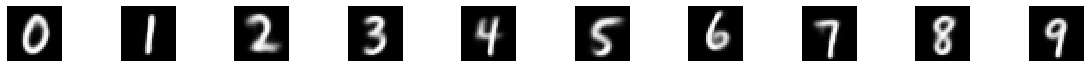

In [11]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np
digit_size = 28
#z_sample = np.random.rand(1, latent_dim) # random 
z_sample = torch.rand(1, latent_dim)
z_sample=z_sample.to(device)
plt.figure(figsize=(20, 1))

for i in range(10):
    #c = np.zeros((1, cond_dim))
    c = torch.zeros((1, cond_dim))
    c=c.to(device)
    c[0][i] = 1
    
    cvae.eval()
    with torch.no_grad():
        img = cvae.decoder(z_sample, c)
        img=img.cpu()
        img=img.numpy()
        # reshape (if needed)
        img=np.reshape(img,[28,28])
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(img, cmap='Greys_r',)
plt.show()

In [13]:
# Create latent space and labels for UMAP
import numpy 
cvae.eval()
latent = np.zeros((10000,latent_dim))
labels = np.zeros((10000,))
with torch.no_grad():
    for i , (data, cond_index) in enumerate(test_loader):
        data = data.view(-1, 784)
        cond = one_hot(cond_index, 10) # create one-hot condition
        cond = cond.to(device)
        data = data.to(device) 
      
        batch_latent = cvae.encoder(data, cond)

        #X_sample, mu, log_sigma, z = cvae(data, cond)
        recon_batch, mu, log_sigma = cvae(data, cond)
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        z= eps.mul(std).add(mu)

        if i == 200:
            latent[i*BATCH_SIZE:i*BATCH_SIZE + BATCH_SIZE//2] = z.cpu()
            labels[i*BATCH_SIZE:i*BATCH_SIZE + BATCH_SIZE//2] = cond_index.numpy()
            breake
        else:
            latent[i*BATCH_SIZE:(i+1)*BATCH_SIZE ] = z.cpu()
            labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = cond_index.numpy()
            # concatenate latent and batch_latent

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
pip install scanpy

     |████████████████████████████████| 317kB 3.5MB/s 
     |████████████████████████████████| 13.0MB 245kB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 51kB 9.8MB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.2
    Uninstalling matplotlib-3.1.2:
      Successfully uninstalled matplotlib-3.1.2


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

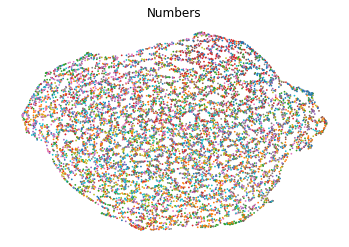

In [16]:
# UMAP
import scanpy as sc

labels = labels.astype(str)
latent_anndata = sc.AnnData(X=latent,
                        obs={"Numbers": labels})
sc.pp.neighbors(latent_anndata)
sc.tl.umap(latent_anndata)

# Visualization
sc.pl.umap(latent_anndata, color=["Numbers"],
           frameon=False,
           legend_loc=False,
           show=True)